### Here we evaluvate the generated sequences and Save metrics to Meta file

In [1]:
import sys
sys.path.append('..')

In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import Bio.PDB

In [5]:
from utils import helper
from utils.hmmtools import HmmerTools
from utils.tmalign import TMalign

In [4]:
root = '../..'
data_path = os.path.join(root, 'Data')
hmm_path = os.path.join('../hmm')

#### Calculating Seq Identity

Sequence identity is calculated against the best protein (highest activity) in the given set

In [6]:
ref_record = helper.read_fasta(os.path.join(data_path, 'sequences_425.fasta'))[0]
gen_records = helper.read_fasta(os.path.join(data_path, 'esm3_gen.fasta'))

In [7]:
seq_ids = {}
for rec in tqdm(gen_records):
    seq_ids[rec.id] = helper.calculate_seq_identity(ref_record, rec)

100%|██████████| 200/200 [00:03<00:00, 64.64it/s]


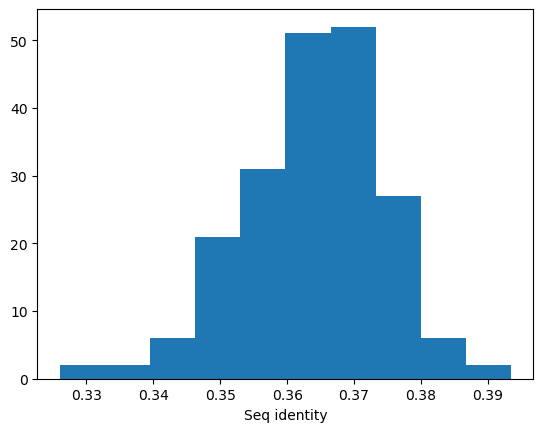

In [8]:
_ = plt.hist(seq_ids.values())
_ = plt.xlabel('Seq identity')

In [9]:
# ## save to metadata
# meta_file = os.path.join(data_path, 'esm3_gen.metadata.json')
# for key in seq_ids:
#     helper.update_metadata_json(meta_file, key, 'seq_id', seq_ids[key])

#### Using HMM search to find domains in the generations

HMMs were retrived from PFAM \
This is to see if the necessary domains for amylase are present or not

In [11]:
a_amylase_catalytic_hmm = os.path.join(hmm_path, 'PF00128.hmm')
a_amylase_all_beta_hmm = os.path.join(hmm_path, 'PF02806.hmm')

In [29]:
meta_file = os.path.join(data_path, 'esm3_gen.metadata.json')

In [38]:
hmms = [a_amylase_catalytic_hmm, a_amylase_all_beta_hmm]
hmmer = HmmerTools()
E_values = []
for key, hmm in zip(['a_amylase_catalytic_hmm', 'a_amylase_all_beta_hmm'], hmms):
    df = hmmer.hmmsearch(hmm_path=hmm, fasta_file=os.path.join(data_path, 'esm3_gen.fasta'))
    E_values.append(-np.log(df['Evalue']))

    ## save to meta file
    # for rec in gen_records:
    #     if rec.id in df['name'].to_list():
    #         helper.update_metadata_json(meta_file, rec.id, key, True)
    #     else:
    #         helper.update_metadata_json(meta_file, rec.id, key, False)

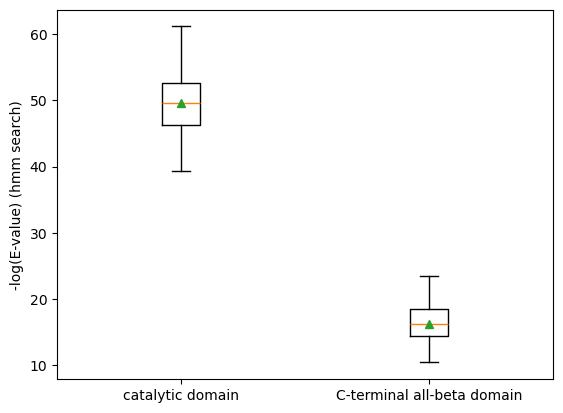

In [39]:
fig, ax = plt.subplots(1,1)
vp = ax.boxplot(E_values, showmeans=True)
_ = ax.set_ylabel('-log(E-value) (hmm search)')
_ = ax.set_xticks(ticks=range(1, len(E_values) + 1), 
              labels=['catalytic domain', 'C-terminal all-beta domain'])

#### Compute TM score to the alpha amylase structure

In [45]:
tm_path = '../utils/TMalign'
ref_structure = os.path.join(data_path, '1bag.protein.pdb')
meta_file = os.path.join(data_path, 'esm3_gen.metadata.json')

tmalign = TMalign(tm_path)
fasta_path = os.path.join(data_path, 'esm3_gen.fasta')
pdbs_path = os.path.join(data_path, 'esm3_pdbs')
tm_scores = []
for f in tqdm(os.listdir(pdbs_path)):
    if f.endswith('.pdb'):
        protein_id = f.replace('.pdb', '')
        file = os.path.join(pdbs_path, f)
        res = tmalign.run(ref_structure, file)

        tm_score = res['tm_score']
        tm_scores.append(tm_score)

        ## save to meta  file
        # helper.update_metadata_json(meta_file, protein_id, 'TM_score', tm_score, force=False)

100%|██████████| 200/200 [00:42<00:00,  4.70it/s]


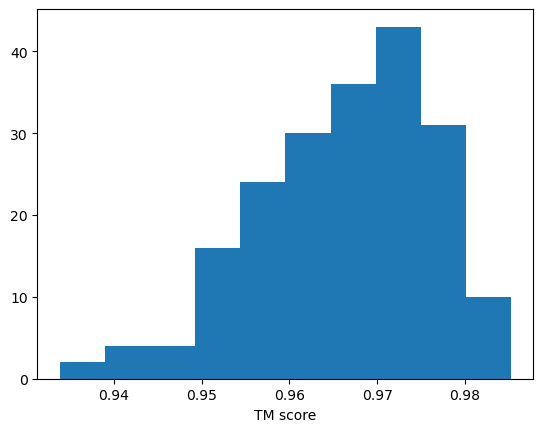

In [46]:
_ = plt.hist(tm_scores)
_ = plt.xlabel('TM score')

#### Computing PLDDT

In [52]:
def get_plddt(file):
    pdbparser = Bio.PDB.PDBParser(QUIET=True)
    struct = pdbparser.get_structure('protein', file)
    plddts = np.array([a.get_bfactor() for a in struct.get_atoms()])
    plddt = plddts.mean()

    return plddt

In [55]:
meta_file = os.path.join(data_path, 'esm3_gen.metadata.json')
fasta_path = os.path.join(data_path, 'esm3_gen.fasta')

plddts = []
pdbs_path = os.path.join(data_path, 'esm3_pdbs')
for f in tqdm(os.listdir(pdbs_path)):
    if f.endswith('.pdb'):
        protein_id = f.replace('.pdb', '')
        file = os.path.join(pdbs_path, f)

        plddt = get_plddt(file)
        plddts.append(plddt)

        ## save to meta  file
        # helper.update_metadata_json(meta_file, protein_id, 'plddt', plddt, force=False)

100%|██████████| 200/200 [00:06<00:00, 30.97it/s]


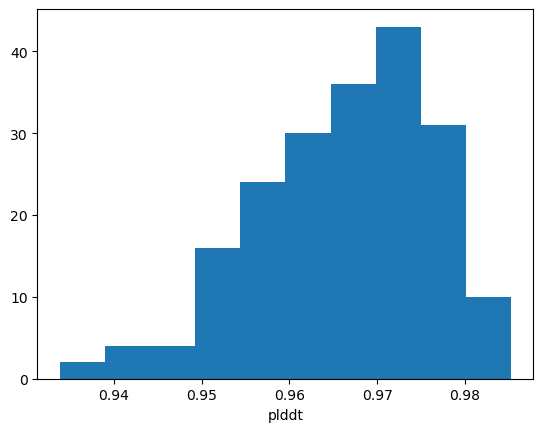

In [56]:
_ = plt.hist(tm_scores)
_ = plt.xlabel('plddt')